# 4 videos from Mouse 7 demo - Analysis

This notebook loads mouse7 data, 
- plots max projection with GT and predicted masks, 
- visualizes ROI area distributions,
- compute and visualize ROIs shape 



In [1]:
# --- Imports and configuration ---
import os, sys, glob, re
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.sparse import csc_matrix
import importlib

# Prefer the git repo; fall back to legacy path. Pick the config that has our set
CANDIDATE_ROOTS = [
    '/gpfs/home/bizzin01/nicole/code/SUNS_nicole_git/Shallow-UNet-Neuron-Segmentation_SUNS'
]
TARGET_SET = '4mouse7_demo_pipeline'
for _root in CANDIDATE_ROOTS:
    if _root not in sys.path:
        sys.path.insert(0, _root)
    try:
        from suns import config as suns_config
        importlib.reload(suns_config)
        if TARGET_SET in suns_config.EXP_ID_SETS:
            break
    except Exception:
        continue

from suns.PreProcessing.preprocessing_functions import find_dataset

print('Using config at:', suns_config.__file__)
print('Available sets:', list(suns_config.EXP_ID_SETS.keys()))

# Dataset selection
active_set = TARGET_SET
exp_id = 'mouse7_776'

# Paths for this dataset
list_Exp_ID = suns_config.EXP_ID_SETS[active_set]
dir_video = suns_config.DATAFOLDER_SETS[active_set]

# Use OUTPUT_FOLDER mapping for this set (not a hardcoded name)
dir_parent = os.path.join(dir_video, suns_config.OUTPUT_FOLDER[active_set])
dir_net_in = os.path.join(dir_parent, 'network_input')
weights_path = os.path.join(dir_parent, 'Weights')
dir_output = os.path.join(dir_parent, 'output_masks')

print('dir_video:', dir_video)
print('dir_parent:', dir_parent)
print('dir_output:', dir_output)


importing config
importing config
Using config at: /gpfs/home/bizzin01/nicole/code/SUNS_nicole_git/Shallow-UNet-Neuron-Segmentation_SUNS/suns/config.py
Available sets: ['data', 'line3_dataset', 'line3_scaled', 'only_mouse7', 'mouse7_new', 'mouse7_suite2pGT', '4video_mouse7', '8videos_mouse7', '4mouse7_demo_pipeline', '4mouse7_pmap']
dir_video: /gpfs/home/bizzin01/nicole/code/SUNS_nicole_git/Shallow-UNet-Neuron-Segmentation_SUNS/demo/4mouse7_demo_pipeline
dir_parent: /gpfs/home/bizzin01/nicole/code/SUNS_nicole_git/Shallow-UNet-Neuron-Segmentation_SUNS/demo/4mouse7_demo_pipeline/output_4mouse7_demo_pipeline
dir_output: /gpfs/home/bizzin01/nicole/code/SUNS_nicole_git/Shallow-UNet-Neuron-Segmentation_SUNS/demo/4mouse7_demo_pipeline/output_4mouse7_demo_pipeline/output_masks


In [2]:
# --- Helper functions ---
from typing import Tuple

def compute_max_projection_from_h5(h5_path: str) -> np.ndarray:
    with h5py.File(h5_path, 'r') as f:
        dset_name = find_dataset(f)
        dset = f[dset_name]
        nframes = dset.shape[0]
        max_img = np.array(dset[0], dtype=np.float32)
        for i in range(1, nframes):
            np.maximum(max_img, dset[i], out=max_img)
    vmin, vmax = float(max_img.min()), float(max_img.max())
    if vmax > vmin:
        max_img = (max_img - vmin) / (vmax - vmin)
    else:
        max_img = np.zeros_like(max_img, dtype=np.float32)
    return max_img


def load_gt_sparse_masks(gt_sparse_path: str, dims: Tuple[int, int]) -> np.ndarray:
    Lx, Ly = dims
    md = loadmat(gt_sparse_path)
    GT = csc_matrix(md['GTMasks_2'])
    pixels = Lx * Ly
    if GT.shape[0] == pixels and GT.shape[1] != pixels:
        GTp = GT
        
    elif GT.shape[1] == pixels and GT.shape[0] != pixels:
        GTp = GT.transpose()
    else:
        GTp = GT
    n_gt = GTp.shape[1]
    masks = np.zeros((n_gt, Lx, Ly), dtype=bool)
    for j in range(n_gt):
        idx = GTp.getcol(j).indices
        masks[j].ravel()[idx] = True
    return masks


def load_pred_masks_from_mat(out_mat_path: str, dims: Tuple[int, int]) -> np.ndarray:
    Lx, Ly = dims
    md = loadmat(out_mat_path)
    m = md.get('Masks')
    if m is None:
        raise RuntimeError("'Masks' not found in output mat")
    m = np.asarray(m)
    if m.ndim != 3:
        raise ValueError(f"Masks must be 3D, got shape {m.shape}")

    # Heuristic: identify which axis is not a spatial dim (Lx or Ly) → that's N
    dims_set = {int(Lx), int(Ly)}
    shape = tuple(int(x) for x in m.shape)
    non_spatial_axes = [ax for ax, sz in enumerate(shape) if sz not in dims_set]

    if len(non_spatial_axes) == 1:
        aN = non_spatial_axes[0]
        other = [ax for ax in range(3) if ax != aN]
        # map Lx/Ly to last two axes in order (Lx, Ly)
        ax_lx = next(ax for ax in other if shape[ax] == Lx)
        ax_ly = next(ax for ax in other if ax != ax_lx)
        masks = np.transpose(m.astype(bool), (aN, ax_lx, ax_ly))
        # ensure (N, Lx, Ly) order; if swapped, fix
        if masks.shape[1:] == (Ly, Lx):
            masks = np.transpose(masks, (0, 2, 1))
    else:
        # Ambiguous (e.g., Lx==Ly==N). Fall back to MATLAB-friendly (Lx, Ly, N) → (N, Lx, Ly)
        masks = np.transpose(m.astype(bool), (2, 0, 1))
        if masks.shape[1:] == (Ly, Lx):
            masks = np.transpose(masks, (0, 2, 1))

    # Final sanity check on spatial dims
    if masks.shape[1:] != (Lx, Ly):
        # try swapping if still mismatched
        if masks.shape[1:] == (Ly, Lx):
            masks = np.transpose(masks, (0, 2, 1))
        else:
            raise ValueError(f"Masks spatial dims {masks.shape[1:]} do not match expected {(Lx, Ly)}")

    return masks


def pad_masks_top_left(masks: np.ndarray, target_dims: Tuple[int, int]) -> np.ndarray:
    """Pad masks (N, Lx_src, Ly_src) into top-left of a (N, Lx_tgt, Ly_tgt) canvas.
    If masks already match target size, returns as-is.
    """
    if masks.ndim != 3:
        raise ValueError('masks must be (N, Lx, Ly)')
    n, Lx_src, Ly_src = masks.shape
    Lx_tgt, Ly_tgt = target_dims
    if (Lx_src, Ly_src) == (Lx_tgt, Ly_tgt):
        return masks
    out = np.zeros((n, Lx_tgt, Ly_tgt), dtype=masks.dtype)
    out[:, :Lx_src, :Ly_src] = masks
    return out


def transform_masks(masks: np.ndarray, rot_k: int = 0, flip_ud: bool = False, flip_lr: bool = False) -> np.ndarray:
    """Apply 90° rotations and flips to masks array (N, Lx, Ly)."""
    if masks.ndim != 3:
        return masks
    out = masks
    rk = rot_k % 4
    if rk:
        out = np.rot90(out, k=rk, axes=(1, 2))
    if flip_ud:
        out = np.flip(out, axis=1)
    if flip_lr:
        out = np.flip(out, axis=2)
    return out


In [3]:
# --- Load data and compute max projection ---
# Prefer the preprocessed network_input for consistency with pipeline
h5_net_in = os.path.join(dir_net_in, f'{exp_id}.h5')
if os.path.exists(h5_net_in):
    with h5py.File(h5_net_in, 'r') as f:
        network_input = np.array(f['network_input'])  # (T, Lx, Ly)
    T, Lx, Ly = network_input.shape
    max_img = network_input.max(axis=0).astype(np.float32)
    vmin, vmax = float(max_img.min()), float(max_img.max())
    if vmax > vmin:
        max_img = (max_img - vmin) / (vmax - vmin)
else:
    # Fallback to raw video
    raw_h5 = os.path.join(dir_video, f'{exp_id}.h5')
    assert os.path.exists(raw_h5), f'Missing video: {raw_h5}'
    max_img = compute_max_projection_from_h5(raw_h5)
    Lx, Ly = max_img.shape

# Load masks
gt_sparse = os.path.join(dir_video, 'GT Masks', f'FinalMasks_{exp_id}_sparse.mat')
if os.path.exists(gt_sparse):
    gt_masks = load_gt_sparse_masks(gt_sparse, (Lx, Ly))
else:
    gt_masks = np.zeros((0, Lx, Ly), dtype=bool)

pred_mat = os.path.join(dir_output, f'Output_Masks_{exp_id}.mat')
if os.path.exists(pred_mat):
    pred_masks = load_pred_masks_from_mat(pred_mat, (Lx, Ly))
else:
    pred_masks = np.zeros((0, Lx, Ly), dtype=bool)

n_gt = gt_masks.shape[0]
n_pred = pred_masks.shape[0]
print(f'N_GT={n_gt}, N_pred={n_pred}, shape={Lx}x{Ly}')


N_GT=757, N_pred=946, shape=256x256


In [4]:
# --- Align GT/Pred to network_input grid while keeping network_input max projection ---
# Read raw dims (fast) and rebuild GT accordingly, then pad to (Lx, Ly)
GT_ROT_K = 1 # default; may be overridden by auto-align
GT_FLIPUD = False
GT_FLIPLR = False

PRED_ROT_K = 0 # default; may be overridden by auto-align
PRED_FLIPUD = False
PRED_FLIPLR = False

raw_h5 = os.path.join(dir_video, f'{exp_id}.h5')
assert os.path.exists(raw_h5), f'Missing video: {raw_h5}'
with h5py.File(raw_h5, 'r') as f:
    dset_name = find_dataset(f)
    Lx_raw, Ly_raw = f[dset_name].shape[1:3]  # no full read, just shape

# Rebuild GT from raw dims
if os.path.exists(gt_sparse):
    gt_masks_raw = load_gt_sparse_masks(gt_sparse, (Lx_raw, Ly_raw))
else:
    gt_masks_raw = np.zeros((0, Lx_raw, Ly_raw), dtype=bool)

# Target dims = network_input dims if available
if 'network_input' in globals():
    Lx_net, Ly_net = network_input.shape[1:]
    max_img_net = network_input.max(axis=0).astype(np.float32)
    vmin_, vmax_ = float(max_img_net.min()), float(max_img_net.max())
    if vmax_ > vmin_:
        max_img_net = (max_img_net - vmin_) / (vmax_ - vmin_)
else:
    Lx_net, Ly_net = Lx, Ly
    # reuse max_img computed earlier
    max_img_net = max_img.astype(np.float32)

# --- Auto-align by maximizing mean max-projection intensity under masks ---
from itertools import product

def _score_alignment(masks_bool, img_f32):
    if masks_bool.size == 0:
        return -np.inf
    # Reduce 3D stacks (N, Lx, Ly) to a 2D union mask for scoring against 2D max projection
    if masks_bool.ndim == 3:
        union = np.any(masks_bool, axis=0)
    elif masks_bool.ndim == 2:
        union = masks_bool
    else:
        return -np.inf
    area = int(union.sum())
    if area == 0:
        return -np.inf
    return float(img_f32[union].mean())

combos = [(k, u, l) for k in range(4) for u in (False, True) for l in (False, True)]

def _best_transform_for_masks(masks_src, src_dims, tgt_dims, img_tgt):
    best = (-np.inf, 0, False, False, None)
    for rk, fud, flr in combos:
        m_tf = transform_masks(masks_src, rot_k=rk, flip_ud=fud, flip_lr=flr)
        # pad/crop to target dims (top-left pad)
        if m_tf.shape[1:] != tgt_dims:
            m_tf = pad_masks_top_left(m_tf, tgt_dims)
        score = _score_alignment(m_tf, img_tgt)
        if score > best[0]:
            best = (score, rk, fud, flr, m_tf)
    return best  # (score, rk, fud, flr, masks_aligned)

# Choose best transform for GT (from raw -> net)
_, GT_ROT_K, GT_FLIPUD, GT_FLIPLR, gt_masks = _best_transform_for_masks(
    gt_masks_raw, (Lx_raw, Ly_raw), (Lx_net, Ly_net), max_img_net
)

# Choose best transform for Pred (handle either raw-sized or net-sized inputs)
if pred_masks.shape[1:] == (Lx_raw, Ly_raw):
    _, PRED_ROT_K, PRED_FLIPUD, PRED_FLIPLR, pred_masks = _best_transform_for_masks(
        pred_masks, (Lx_raw, Ly_raw), (Lx_net, Ly_net), max_img_net
    )
else:
    _, PRED_ROT_K, PRED_FLIPUD, PRED_FLIPLR, pred_masks = _best_transform_for_masks(
        pred_masks, pred_masks.shape[1:], (Lx_net, Ly_net), max_img_net
    )

# Update counters and dimensions for plotting
Lx, Ly = Lx_net, Ly_net
n_gt = gt_masks.shape[0]
n_pred = pred_masks.shape[0]
print(
    f'Aligned: raw={Lx_raw}x{Ly_raw} -> net_in={Lx}x{Ly}; '
    f'N_GT={n_gt}, N_pred={n_pred}; '
    f'GT(rot={GT_ROT_K},ud={GT_FLIPUD},lr={GT_FLIPLR}), '
    f'PRED(rot={PRED_ROT_K},ud={PRED_FLIPUD},lr={PRED_FLIPLR})'
)


Aligned: raw=256x256 -> net_in=256x256; N_GT=757, N_pred=946; GT(rot=1,ud=True,lr=False), PRED(rot=1,ud=True,lr=False)


Saved overlay to: /gpfs/home/bizzin01/nicole/code/SUNS_nicole_git/Shallow-UNet-Neuron-Segmentation_SUNS/demo/4mouse7_demo_pipeline/output_4mouse7_demo_pipeline/overlay_mouse7_776.png


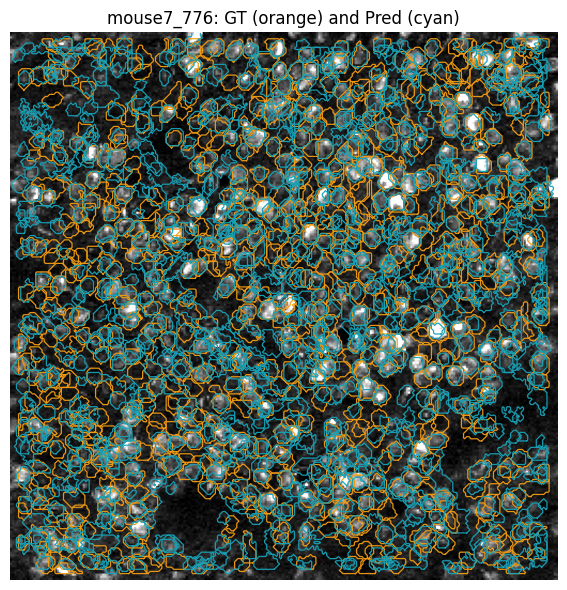

Saved triptych to: /gpfs/home/bizzin01/nicole/code/SUNS_nicole_git/Shallow-UNet-Neuron-Segmentation_SUNS/demo/4mouse7_demo_pipeline/output_4mouse7_demo_pipeline/overlay_triptych_mouse7_776.png


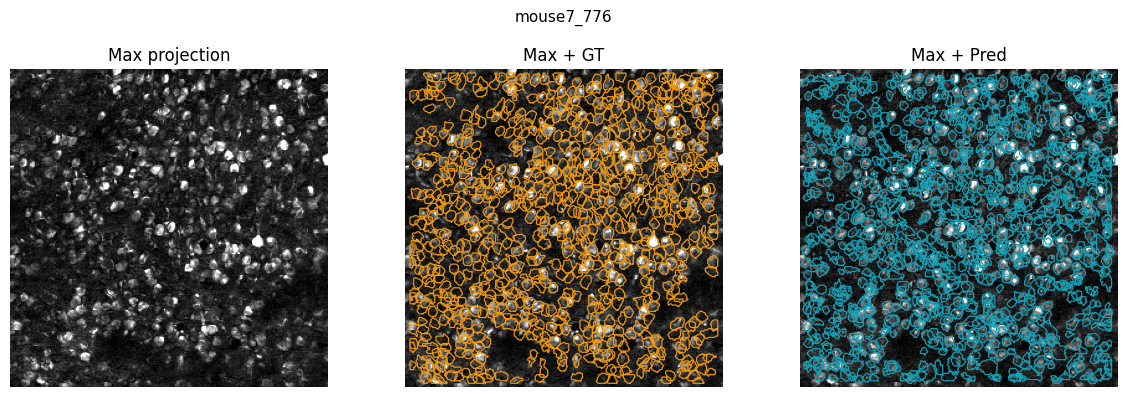

In [5]:
# --- Static overlay (no GUI) of GT & Pred on max projection ---
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure


def plot_overlay_maxproj(max_img, gt_masks, pred_masks, out_path=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    vmin, vmax = np.percentile(max_img, (1, 99))
    ax.imshow(max_img, cmap='gray', vmin=vmin, vmax=vmax)

    # GT in orange
    for i in range(gt_masks.shape[0]):
        m = gt_masks[i]
        if m.any():
            for c in measure.find_contours(m.astype(float), 0.5):
                ax.plot(c[:, 1], c[:, 0], color='#F39C12', lw=0.9, alpha=0.95)

    # Pred in cyan
    for i in range(pred_masks.shape[0]):
        m = pred_masks[i]
        if m.any():
            for c in measure.find_contours(m.astype(float), 0.5):
                ax.plot(c[:, 1], c[:, 0], color='#17A2B8', lw=0.9, alpha=0.95)

    ax.set_title(f"{exp_id}: GT (orange) and Pred (cyan)")
    ax.axis('off')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=200)
        print('Saved overlay to:', out_path)
    plt.show()


def _draw_contours(ax, masks, color, lw=0.9, alpha=0.95):
    for i in range(masks.shape[0]):
        m = masks[i]
        if m.any():
            for c in measure.find_contours(m.astype(float), 0.5):
                ax.plot(c[:, 1], c[:, 0], color=color, lw=lw, alpha=alpha)


def plot_overlay_triptych(max_img, gt_masks, pred_masks, out_path=None):
    vmin, vmax = np.percentile(max_img, (1, 99))
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # 1) Max projection only
    axes[0].imshow(max_img, cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title('Max projection')
    axes[0].axis('off')

    # 2) Max + GT
    axes[1].imshow(max_img, cmap='gray', vmin=vmin, vmax=vmax)
    _draw_contours(axes[1], gt_masks, color='#F39C12')
    axes[1].set_title('Max + GT')
    axes[1].axis('off')

    # 3) Max + Pred
    axes[2].imshow(max_img, cmap='gray', vmin=vmin, vmax=vmax)
    _draw_contours(axes[2], pred_masks, color='#17A2B8')
    axes[2].set_title('Max + Pred')
    axes[2].axis('off')

    fig.suptitle(exp_id, y=0.98, fontsize=11)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if out_path:
        plt.savefig(out_path, dpi=200)
        print('Saved triptych to:', out_path)
    plt.show()

# Ensure we have a max image
if 'max_img' not in globals():
    if 'network_input' in globals():
        max_img = network_input.max(axis=0).astype(np.float32)
        vmin, vmax = float(max_img.min()), float(max_img.max())
        if vmax > vmin:
            max_img = (max_img - vmin) / (vmax - vmin)
    else:
        raw_h5 = os.path.join(dir_video, f'{exp_id}.h5')
        assert os.path.exists(raw_h5), f'Missing video: {raw_h5}'
        max_img = compute_max_projection_from_h5(raw_h5)

# Save next to outputs
out_png = os.path.join(dir_parent, f'overlay_{exp_id}.png')
plot_overlay_maxproj(max_img, gt_masks, pred_masks, out_path=out_png)

# Triptych (1x3) figure
out_png3 = os.path.join(dir_parent, f'overlay_triptych_{exp_id}.png')
plot_overlay_triptych(max_img, gt_masks, pred_masks, out_path=out_png3)



Matched pairs (IoU≥0.2): 553
IoU percentiles: [0.25454545 0.43859649 0.56603771 0.67307693 0.80112678]


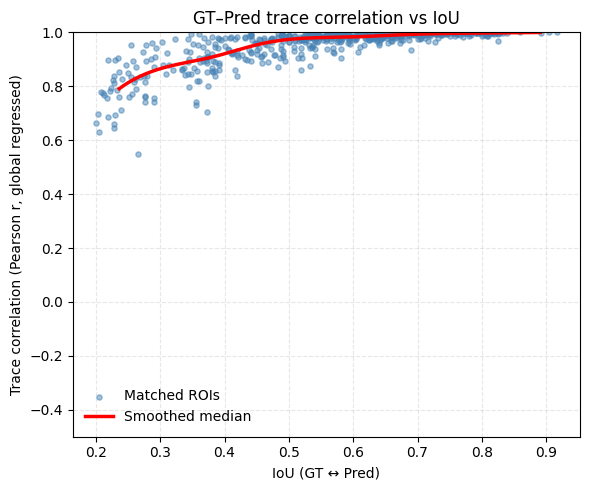

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# -------- helpers --------
def ensure_stack_first(masks):
    # Accept (N,Y,X) or (Y,X,N); return (N,Y,X)
    if masks.ndim != 3:
        raise ValueError("masks must be 3D")
    if masks.shape[0] in (masks.shape[1], masks.shape[2]) and masks.shape[0] != masks.shape[-1]:
        # likely (Y,X,N)
        return np.moveaxis(masks, -1, 0)
    return masks

def pairwise_iou(A_bool, B_bool):
    A_bool = ensure_stack_first(A_bool).astype(bool)
    B_bool = ensure_stack_first(B_bool).astype(bool)
    Na, H, W = A_bool.shape
    Nb = B_bool.shape[0]
    A2 = A_bool.reshape(Na, -1).astype(np.uint8)
    B2 = B_bool.reshape(Nb, -1).astype(np.uint8)
    inter = A2 @ B2.T                           # (Na,Nb) pixel intersections
    a_sum = A2.sum(axis=1, keepdims=True)       # (Na,1)
    b_sum = B2.sum(axis=1, keepdims=True).T     # (1,Nb)
    union = a_sum + b_sum - inter
    I = np.zeros_like(inter, dtype=np.float32)
    valid = union > 0
    I[valid] = inter[valid] / union[valid]
    return I

def extract_mean_traces(video_T_y_x, masks_bool):
    masks_bool = ensure_stack_first(masks_bool).astype(bool)
    T = video_T_y_x.shape[0]
    traces = np.zeros((masks_bool.shape[0], T), dtype=np.float32)
    for i, m in enumerate(masks_bool):
        if m.any():
            traces[i] = video_T_y_x[:, m].mean(axis=1)
    return traces

def zscore_rows(X, eps=1e-8):
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True) + eps
    return (X - mu) / sd

def regress_out_global(traces, global_trace):
    # remove projection onto the global signal: r = t - ((t·g)/(g·g)) g
    g = (global_trace - global_trace.mean()) / (global_trace.std() + 1e-8)
    gg = np.dot(g, g) + 1e-8
    proj = (traces @ g[None, :].T) / gg           # (N,1)
    return traces - proj * g[None, :]

# -------- compute IoU & match with threshold --------
IoU = pairwise_iou(gt_masks, pred_masks)

tau = 0.2 # <-- set acceptance threshold here
cost = 1.0 - IoU
cost[IoU < tau] = 1e6                            # forbid low-overlap pairs

row_ind, col_ind = linear_sum_assignment(cost)
matched_iou = IoU[row_ind, col_ind]
keep = matched_iou >= tau
row_ind, col_ind, matched_iou = row_ind[keep], col_ind[keep], matched_iou[keep]

print(f"Matched pairs (IoU≥{tau}): {len(matched_iou)}")
print("IoU percentiles:", np.percentile(matched_iou, [5,25,50,75,95]))

# -------- traces, z-score, and global/neuropil removal --------
# network_input : (T,Y,X) – same movie used for both GT and Pred
gt_tr  = extract_mean_traces(network_input, gt_masks)   # (N_gt, T)
pr_tr  = extract_mean_traces(network_input, pred_masks) # (N_pr, T)

# remove FOV global signal (crude neuropil/global correction)
gtrace = network_input.mean(axis=(1,2)).astype(np.float32)  # (T,)
gt_tr = regress_out_global(gt_tr, gtrace)
pr_tr = regress_out_global(pr_tr, gtrace)

# z-score rows
gt_z = zscore_rows(gt_tr)
pr_z = zscore_rows(pr_tr)

# -------- correlations per matched pair --------
corrs = np.empty_like(matched_iou, dtype=np.float32)
for k, (gi, pi) in enumerate(zip(row_ind, col_ind)):
    t1, t2 = gt_z[gi], pr_z[pi]
    T_use = min(t1.size, t2.size)
    r = np.corrcoef(t1[:T_use], t2[:T_use])[0, 1]
    corrs[k] = r

# -------- plot: scatter + binned trend --------
# -------- plot: scatter + smooth red trend line --------
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

x, y = matched_iou, corrs

plt.figure(figsize=(6,5))
plt.scatter(x, y, s=14, alpha=0.5, color='steelblue', label='Matched ROIs')

# compute median per bin (for a stable baseline)
bins = np.linspace(tau, 1.0, 12)
centers = 0.5*(bins[:-1] + bins[1:])
med = [np.median(y[(x>=bins[i]) & (x<bins[i+1])]) if np.any((x>=bins[i]) & (x<bins[i+1])) else np.nan
       for i in range(len(bins)-1)]
centers, med = np.array(centers), np.array(med)

# smooth with a spline (cubic)
mask = np.isfinite(med)
if np.sum(mask) >= 4:
    spline = make_interp_spline(centers[mask], med[mask], k=3)
    x_smooth = np.linspace(centers[mask].min(), centers[mask].max(), 300)
    y_smooth = spline(x_smooth)
    plt.plot(x_smooth, y_smooth, color='red', lw=2.5, label='Smoothed median')
else:
    plt.plot(centers, med, color='red', lw=2.5, label='Median (unsmoothed)') # change color to red

plt.xlabel('IoU (GT ↔ Pred)')
plt.ylabel('Trace correlation (Pearson r, global regressed)')
#plt.title('GT–Pred trace correlation vs IoU (τ = %.2f)' % tau)
plt.title('GT–Pred trace correlation vs IoU')
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(-0.5, 1.0)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# The plot compares spatial overlap (IoU) with temporal similarity 
# (correlation of calcium traces) between matched ROIs from  
# two segmentation methods.
# Each blue dot is one matched neuron pair (GT - Pred).


In [10]:
# --- Precision, Recall, F1 at IoU thresholds 0.3 and 0.2 ---
from scipy.optimize import linear_sum_assignment
import numpy as np


def prf_from_iou(iou_matrix: np.ndarray, thr: float):
    """Compute TP/FP/FN, precision, recall, F1 given an IoU matrix and threshold.
    Matching is done one-to-one via Hungarian assignment with pairs < thr disallowed.
    """
    if iou_matrix.size == 0:
        return dict(tp=0, fp=0, fn=0, precision=0.0, recall=0.0, f1=0.0)

    n_gt, n_pr = iou_matrix.shape
    cost = 1.0 - iou_matrix
    cost[iou_matrix < thr] = 1e6
    gi, pi = linear_sum_assignment(cost)
    matched = iou_matrix[gi, pi] >= thr

    tp = int(matched.sum())
    fp = int(n_pr - tp)
    fn = int(n_gt - tp)

    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    return dict(tp=tp, fp=fp, fn=fn, precision=precision, recall=recall, f1=f1)


# Using the IoU matrix computed above (GT x Pred)
for thr in (0.3, 0.2):
    m = prf_from_iou(IoU, thr)
    print(
        f"IoU ≥ {thr:.1f}: TP={m['tp']} FP={m['fp']} FN={m['fn']} | "
        f"P={m['precision']:.3f} R={m['recall']:.3f} F1={m['f1']:.3f}"
    )



IoU ≥ 0.3: TP=503 FP=443 FN=254 | P=0.532 R=0.664 F1=0.591
IoU ≥ 0.2: TP=553 FP=393 FN=204 | P=0.585 R=0.731 F1=0.649


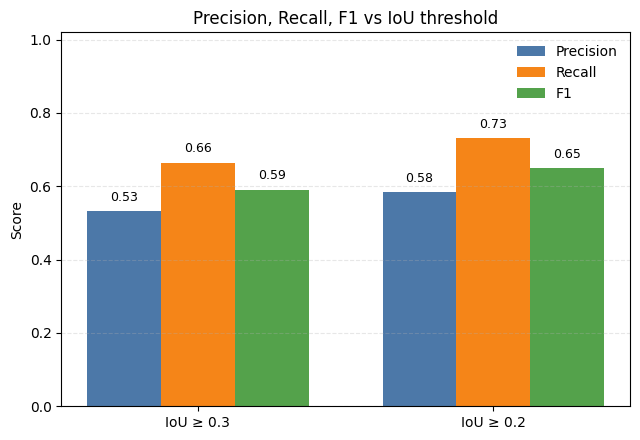

In [11]:
# --- Bar plot: Precision, Recall, F1 at IoU thresholds 0.3 and 0.2 ---
import numpy as np
import matplotlib.pyplot as plt

thr_list = [0.3, 0.2]
metrics = {'Precision': [], 'Recall': [], 'F1': []}

for thr in thr_list:
    m = prf_from_iou(IoU, thr)
    metrics['Precision'].append(m['precision'])
    metrics['Recall'].append(m['recall'])
    metrics['F1'].append(m['f1'])

x = np.arange(len(thr_list))
w = 0.25

fig, ax = plt.subplots(figsize=(6.5, 4.5))
ax.bar(x - w, metrics['Precision'], width=w, label='Precision', color='#4C78A8')
ax.bar(x,      metrics['Recall'],    width=w, label='Recall',    color='#F58518')
ax.bar(x + w,  metrics['F1'],        width=w, label='F1',        color='#54A24B')

ax.set_xticks(x)
ax.set_xticklabels([f'IoU ≥ {t:.1f}' for t in thr_list])
ax.set_ylim(0, 1.02)
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, F1 vs IoU threshold')
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.legend(frameon=False)

# annotate bar values
for i in range(len(thr_list)):
    vals = [metrics['Precision'][i], metrics['Recall'][i], metrics['F1'][i]]
    for j, val in enumerate(vals):
        xpos = x[i] + (j-1)*w
        ax.text(xpos, min(val + 0.02, 1.02), f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



**Consume ratio (what it is and where it is set)**

- The post-processing merges masks that have a high one-sided overlap called "consume ratio": intersection/area of the source mask. In code, consume is computed as intersection divided by the area of mask i:

```249:256:suns/PostProcessing/combine.py
area_i = tempmasks.dot(tempmasks.T).toarray()
area = area_i.diagonal()
area_i = area_i - np.diag(area)
a2 = np.expand_dims(area, axis=0).repeat(N, axis=0)
consume = area_i / a2
```

- The threshold used for this merge is `Params['thresh_consume']` when running the complete post-processing:

```36:41:suns/PostProcessing/complete_post.py
Params['thresh_COM']: Threshold of COM distance (unit: pixels) used for the second COM-based merging. 
Params['thresh_IOU']: Threshold of IOU used for merging neurons.
Params['thresh_consume']: Threshold of consume ratio used for merging neurons.
Params['cons']: Minimum number of consecutive frames that a neuron should be active for.
```

- When only optimizing a subset of parameters, the code sets a default relation between consume-threshold and IoU-threshold as:

```164:168:suns/PostProcessing/complete_post.py
thresh_IOU = Params['thresh_IOU']
thresh_consume = (1+thresh_IOU)/2
list_cons = Params['list_cons']
```

In other words, if IoU threshold is 0.3, the default consume threshold becomes 0.65; if IoU is 0.2, consume becomes 0.60. Below we compute metrics using consume ratio instead of IoU.


Consume-based matching metrics:
IoU thr 0.3 -> consume thr 0.65 | TP=509 FP=437 FN=248 | P=0.538 R=0.672 F1=0.598
IoU thr 0.2 -> consume thr 0.60 | TP=521 FP=425 FN=236 | P=0.551 R=0.688 F1=0.612


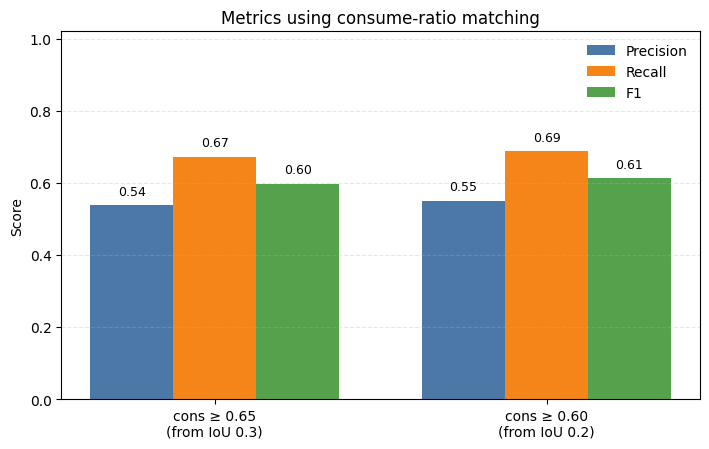

In [12]:
# --- Metrics using consume ratio (directional overlap) ---
import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt


def pairwise_intersection_and_areas(A_bool, B_bool):
    A = ensure_stack_first(A_bool).astype(bool).reshape(A_bool.shape[0], -1).astype(np.uint8)
    B = ensure_stack_first(B_bool).astype(bool).reshape(B_bool.shape[0], -1).astype(np.uint8)
    inter = A @ B.T  # (Na, Nb)
    area_A = A.sum(axis=1)  # (Na,)
    area_B = B.sum(axis=1)  # (Nb,)
    return inter.astype(np.float32), area_A.astype(np.float32), area_B.astype(np.float32)


def pairwise_consume_matrix(gt_masks_bool, pr_masks_bool):
    """Return directional and symmetric consume matrices between GT and Pred.
    consume_gt[i,j] = |Gi ∩ Pj| / |Gi|
    consume_pr[i,j] = |Gi ∩ Pj| / |Pj|
    consume_sym = max(consume_gt, consume_pr)
    """
    inter, area_g, area_p = pairwise_intersection_and_areas(gt_masks_bool, pr_masks_bool)
    # Avoid division by zero
    area_g = np.maximum(area_g, 1.0)
    area_p = np.maximum(area_p, 1.0)
    consume_gt = inter / area_g[:, None]
    consume_pr = inter / area_p[None, :]
    consume_sym = np.maximum(consume_gt, consume_pr)
    return consume_gt, consume_pr, consume_sym


def prf_from_consume(consume_mat_sym: np.ndarray, thr: float):
    if consume_mat_sym.size == 0:
        return dict(tp=0, fp=0, fn=0, precision=0.0, recall=0.0, f1=0.0)
    n_gt, n_pr = consume_mat_sym.shape
    cost = 1.0 - consume_mat_sym
    cost[consume_mat_sym < thr] = 1e6
    gi, pi = linear_sum_assignment(cost)
    matched = consume_mat_sym[gi, pi] >= thr
    tp = int(matched.sum())
    fp = int(n_pr - tp)
    fn = int(n_gt - tp)
    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)
    return dict(tp=tp, fp=fp, fn=fn, precision=precision, recall=recall, f1=f1)


# Compute consume matrices (GT vs Pred)
cons_gt, cons_pr, cons_sym = pairwise_consume_matrix(gt_masks, pred_masks)

# Map the IoU thresholds used above (0.3, 0.2) to default consume thresholds
thr_pairs = [(0.3, (1+0.3)/2), (0.2, (1+0.2)/2)]  # (IoU, consume)

print('Consume-based matching metrics:')
for iou_thr, cons_thr in thr_pairs:
    m = prf_from_consume(cons_sym, cons_thr)
    print(f"IoU thr {iou_thr:.1f} -> consume thr {cons_thr:.2f} | "
          f"TP={m['tp']} FP={m['fp']} FN={m['fn']} | P={m['precision']:.3f} R={m['recall']:.3f} F1={m['f1']:.3f}")

# Plot grouped bars for consume thresholds
thr_labels = [f"cons ≥ {c:.2f}\n(from IoU {i:.1f})" for i, c in thr_pairs]
metrics = {'Precision': [], 'Recall': [], 'F1': []}
for _, cons_thr in thr_pairs:
    m = prf_from_consume(cons_sym, cons_thr)
    metrics['Precision'].append(m['precision'])
    metrics['Recall'].append(m['recall'])
    metrics['F1'].append(m['f1'])

x = np.arange(len(thr_pairs)); w = 0.25
fig, ax = plt.subplots(figsize=(7.2, 4.6))
ax.bar(x - w, metrics['Precision'], width=w, label='Precision', color='#4C78A8')
ax.bar(x,      metrics['Recall'],    width=w, label='Recall',    color='#F58518')
ax.bar(x + w,  metrics['F1'],        width=w, label='F1',        color='#54A24B')
ax.set_xticks(x); ax.set_xticklabels(thr_labels)
ax.set_ylim(0, 1.02)
ax.set_ylabel('Score')
ax.set_title('Metrics using consume-ratio matching')
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.legend(frameon=False)
for i in range(len(thr_pairs)):
    for j, key in enumerate(['Precision', 'Recall', 'F1']):
        val = metrics[key][i]; xpos = x[i] + (j-1)*w
        ax.text(xpos, min(val + 0.02, 1.02), f'{val:.2f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout(); plt.show()



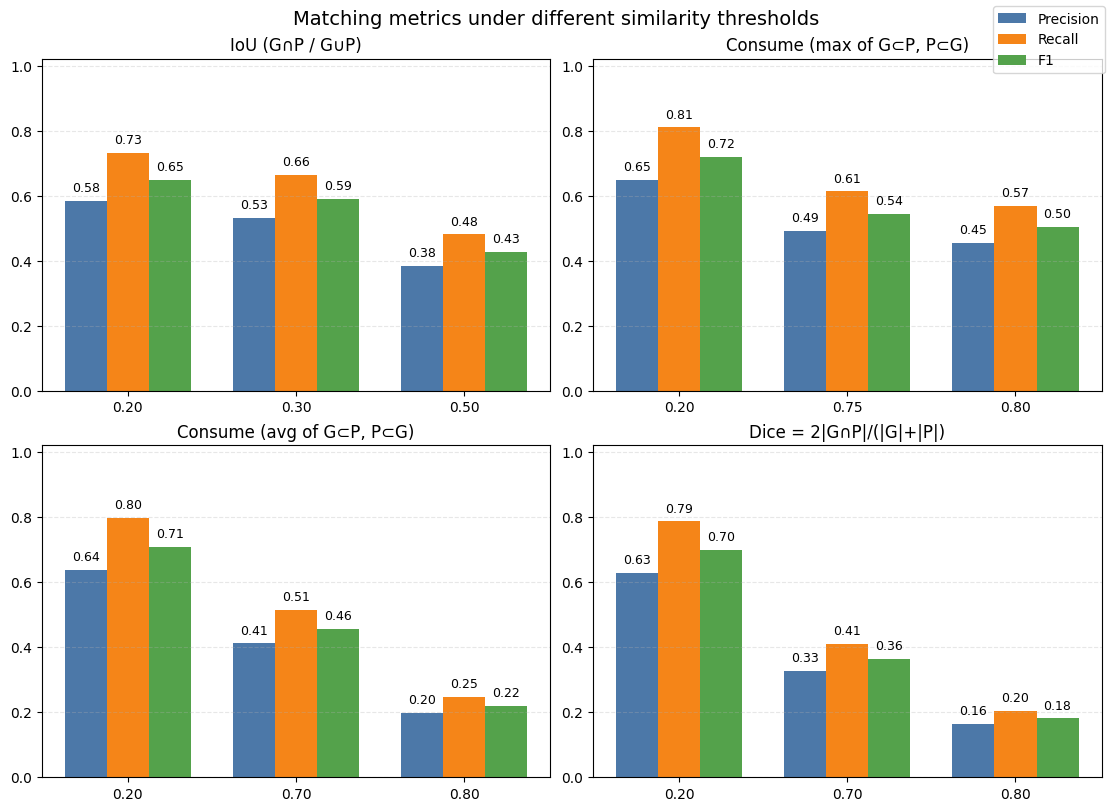

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# ------------------------- INPUTS -------------------------
# Expected inputs already in memory:
#   gt_masks   : (N_gt, H, W) boolean
#   pred_masks : (N_pr, H, W) boolean
#
# If your arrays are not boolean or not (N,H,W), adapt below or cast:
# gt_masks = gt_masks.astype(bool)
# pred_masks = pred_masks.astype(bool)
# ----------------------------------------------------------

def ensure_stack_first(X):
    """Return masks as (N,H,W). Accepts (N,H,W) or (H,W,N)."""
    X = np.asarray(X)
    if X.ndim != 3:
        raise ValueError(f"Expected 3D array for masks, got shape {X.shape}")
    # If first dim is small and last dim is large, assume (H,W,N)
    if X.shape[0] <= 8 and X.shape[-1] > 8:
        X = np.transpose(X, (2,0,1))
    return X

def pairwise_intersection_and_areas(A_bool, B_bool):
    A = ensure_stack_first(A_bool).astype(bool).reshape(A_bool.shape[0], -1).astype(np.uint8)
    B = ensure_stack_first(B_bool).astype(bool).reshape(B_bool.shape[0], -1).astype(np.uint8)
    inter = A @ B.T                        # (Na, Nb) intersection areas
    area_A = A.sum(axis=1).astype(np.float32)  # (Na,)
    area_B = B.sum(axis=1).astype(np.float32)  # (Nb,)
    return inter.astype(np.float32), area_A, area_B

def pairwise_overlap_metrics(gt_masks_bool, pr_masks_bool):
    """Return dict of IoU, consume_max, consume_avg, dice pairwise matrices (n_gt x n_pr)."""
    inter, area_g, area_p = pairwise_intersection_and_areas(gt_masks_bool, pr_masks_bool)
    # avoid zero division
    area_g = np.maximum(area_g, 1.0)
    area_p = np.maximum(area_p, 1.0)
    # metrics
    iou = inter / (area_g[:, None] + area_p[None, :] - inter + 1e-8)
    cons_g = inter / area_g[:, None]
    cons_p = inter / area_p[None, :]
    consume_max = np.maximum(cons_g, cons_p)
    consume_avg = 0.5 * (cons_g + cons_p)
    dice = 2.0 * inter / (area_g[:, None] + area_p[None, :] + 1e-8)
    return dict(iou=iou, consume_max=consume_max, consume_avg=consume_avg, dice=dice)

def match_metrics_from_similarity(S, thr):
    """
    Given a similarity matrix S (n_gt x n_pr) and threshold thr,
    do 1-1 matching with Hungarian assignment on cost = 1 - S (masking pairs < thr),
    then compute P/R/F1.
    """
    if S.size == 0:
        return dict(tp=0, fp=0, fn=0, precision=0.0, recall=0.0, f1=0.0)

    n_gt, n_pr = S.shape
    cost = 1.0 - S.copy()
    cost[S < thr] = 1e6  # disallow pairs below threshold
    gi, pi = linear_sum_assignment(cost)
    matched = S[gi, pi] >= thr
    tp = int(matched.sum())
    fp = int(n_pr - tp)
    fn = int(n_gt - tp)
    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)
    return dict(tp=tp, fp=fp, fn=fn, precision=precision, recall=recall, f1=f1)

def plot_metric_panel(ax, name, S, thresholds, colors=None):
    """Grouped bar chart of P/R/F1 for a set of thresholds on a given similarity matrix S."""
    if colors is None:
        colors = dict(Precision='#4C78A8', Recall='#F58518', F1='#54A24B')

    metrics = {'Precision': [], 'Recall': [], 'F1': []}
    for thr in thresholds:
        m = match_metrics_from_similarity(S, thr)
        metrics['Precision'].append(m['precision'])
        metrics['Recall'].append(m['recall'])
        metrics['F1'].append(m['f1'])

    x = np.arange(len(thresholds)); w = 0.25
    ax.bar(x - w, metrics['Precision'], width=w, label='Precision', color=colors['Precision'])
    ax.bar(x,      metrics['Recall'],    width=w, label='Recall',    color=colors['Recall'])
    ax.bar(x + w,  metrics['F1'],        width=w, label='F1',        color=colors['F1'])
    ax.set_xticks(x)
    ax.set_xticklabels([f"{t:.2f}" for t in thresholds])
    ax.set_ylim(0, 1.02)
    ax.set_title(name)
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    # annotate bars
    for i in range(len(thresholds)):
        for j, key in enumerate(['Precision', 'Recall', 'F1']):
            val = metrics[key][i]
            xpos = x[i] + (j-1)*w
            ax.text(xpos, min(val + 0.02, 1.02), f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# -------- compute matrices --------
gt_masks_bool   = gt_masks.astype(bool)
pred_masks_bool = pred_masks.astype(bool)
M = pairwise_overlap_metrics(gt_masks_bool, pred_masks_bool)

# -------- thresholds per metric (edit as you like) --------
thr_iou   = [0.20, 0.30, 0.50]
thr_cmax  = [0.20, 0.75, 0.80]   # consume_max (SUNS often uses (1+IoU)/2; IoU=0.5 -> 0.75)
thr_cavg  = [0.20, 0.70, 0.80]   # consume_avg (softer aggregation)
thr_dice  = [0.20, 0.70, 0.80]

# -------- plot 2x2 panels --------
fig, axes = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)

plot_metric_panel(axes[0,0], 'IoU (G∩P / G∪P)',           M['iou'],         thr_iou)
plot_metric_panel(axes[0,1], 'Consume (max of G⊂P, P⊂G)', M['consume_max'], thr_cmax)
plot_metric_panel(axes[1,0], 'Consume (avg of G⊂P, P⊂G)', M['consume_avg'], thr_cavg)
plot_metric_panel(axes[1,1], 'Dice = 2|G∩P|/(|G|+|P|)',    M['dice'],        thr_dice)

# single legend at top-right
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

fig.suptitle('Matching metrics under different similarity thresholds', fontsize=14)
plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from scipy.optimize import linear_sum_assignment

# ---------- utilities ----------
def ensure_stack_first(masks):
    if masks.ndim != 3:
        raise ValueError("masks must be 3D")
    if masks.shape[0] in (masks.shape[1], masks.shape[2]) and masks.shape[0] != masks.shape[-1]:
        return np.moveaxis(masks, -1, 0)
    return masks

def pairwise_iou(A_bool, B_bool):
    A_bool = ensure_stack_first(A_bool).astype(bool)
    B_bool = ensure_stack_first(B_bool).astype(bool)
    Na, H, W = A_bool.shape
    Nb = B_bool.shape[0]
    A2 = A_bool.reshape(Na, -1).astype(np.uint8)
    B2 = B_bool.reshape(Nb, -1).astype(np.uint8)
    inter = A2 @ B2.T
    a_sum = A2.sum(axis=1, keepdims=True)
    b_sum = B2.sum(axis=1, keepdims=True).T
    union = a_sum + b_sum - inter
    I = np.zeros_like(inter, dtype=np.float32)
    valid = union > 0
    I[valid] = inter[valid] / union[valid]
    return I

def roi_trace(video_TYX, mask_YX):
    if not mask_YX.any():
        return np.zeros(video_TYX.shape[0], dtype=np.float32)
    return video_TYX[:, mask_YX].mean(axis=1)

def zscore(x, eps=1e-8):
    return (x - x.mean()) / (x.std() + eps)

def regress_out_global(trace, g):
    g = (g - g.mean()) / (g.std() + 1e-8)
    gg = np.dot(g, g) + 1e-8
    return trace - (np.dot(trace, g) / gg) * g

def center_of_mass(mask):
    y, x = ndi.center_of_mass(mask.astype(float))
    if np.isnan(y):  # fallback
        H, W = mask.shape
        return H/2, W/2
    return y, x

def crop(arr_YX, cy, cx, half=28):
    H, W = arr_YX.shape
    y1, y2 = int(cy-half), int(cy+half+1)
    x1, x2 = int(cx-half), int(cx+half+1)
    py1, py2 = max(0,-y1), max(0,y2-H)
    px1, px2 = max(0,-x1), max(0,x2-W)
    y1c, y2c = max(0,y1), min(H,y2)
    x1c, x2c = max(0,x1), min(W,x2)
    patch = arr_YX[y1c:y2c, x1c:x2c]
    if py1 or py2 or px1 or px2:
        patch = np.pad(patch, ((py1,py2),(px1,px2)), mode='edge')
    return patch

# ---------- main: overlay masks + overlapped traces ----------
def show_pairs_overlay_and_traces(
    video_TYX, gt_masks, pred_masks,
    pairs=None, iou_threshold=0.3, n_pairs=6, half=28,
    global_regress=True, zscore_tr=True, sort_by="IoU"
):
    """
    For each pair: left subplot = max-projection patch with GT (orange) + Pred (cyan) contours.
                   right subplot = overlapped traces (GT vs Pred) on same axes.
    Titles show IoU and Pearson r.
    """
    gt_masks = ensure_stack_first(gt_masks).astype(bool)
    pred_masks = ensure_stack_first(pred_masks).astype(bool)

    # match if not provided
    if pairs is None:
        I = pairwise_iou(gt_masks, pred_masks)
        cost = 1.0 - I
        cost[I < iou_threshold] = 1e6
        gi, pi = linear_sum_assignment(cost)
        m_iou = I[gi, pi]
        keep = m_iou >= iou_threshold
        gi, pi, m_iou = gi[keep], pi[keep], m_iou[keep]
        pairs = list(zip(gi, pi))
        ious = m_iou
    else:
        # compute IoU for the provided pairs for sorting/annotation
        I = pairwise_iou(gt_masks, pred_masks)
        ious = np.array([I[g, p] for g, p in pairs])

    # pick subset
    if sort_by.lower() == "iou":
        order = np.argsort(ious)[::-1]
    else:
        order = np.arange(len(pairs))
    sel = order[:min(n_pairs, len(pairs))]
    pairs_sel = [pairs[i] for i in sel]
    ious_sel  = ious[sel]

    # global signal for optional regression
    g = video_TYX.mean(axis=(1,2)) if global_regress else None

    # figure
    n = len(pairs_sel)
    n_cols = 2
    n_rows = n
    fig = plt.figure(figsize=(8.8, 2.8*n_rows))

    maxproj = video_TYX.max(axis=0)
    vmin, vmax = np.percentile(maxproj, (1, 99))

    for row, ((gidx, pidx), iou_val) in enumerate(zip(pairs_sel, ious_sel), start=1):
        mgt = gt_masks[gidx]; mpr = pred_masks[pidx]

        # center crop around the average COM
        y1, x1 = center_of_mass(mgt); y2, x2 = center_of_mass(mpr)
        cy, cx = (y1+y2)/2, (x1+x2)/2
        patch = crop(maxproj, cy, cx, half=half)
        mgt_c = crop(mgt.astype(float), cy, cx, half=half) > 0.5
        mpr_c = crop(mpr.astype(float), cy, cx, half=half) > 0.5

        # traces
        t_gt = roi_trace(video_TYX, mgt)
        t_pr = roi_trace(video_TYX, mpr)
        if global_regress:
            t_gt = regress_out_global(t_gt, g)
            t_pr = regress_out_global(t_pr, g)
        if zscore_tr:
            t_gt = zscore(t_gt); t_pr = zscore(t_pr)

        # correlation
        r = np.corrcoef(t_gt, t_pr)[0,1]

        # --- left: image + both contours ---
        axL = plt.subplot(n_rows, n_cols, 2*row-1)
        axL.imshow(patch, cmap='gray', vmin=vmin, vmax=vmax)
        axL.contour(mgt_c, levels=[0.5], colors='#F39C12', linewidths=1.6, alpha=0.95, linestyles='-')   # GT: orange
        axL.contour(mpr_c, levels=[0.5], colors='#17A2B8', linewidths=1.6, alpha=0.95, linestyles='-')   # Pred: cyan
        axL.set_title(f"GT #{gidx} vs Pred #{pidx}\nIoU={iou_val:.2f}, r={r:.2f}")
        axL.axis('off')

        # --- right: overlapped traces ---
        axR = plt.subplot(n_rows, n_cols, 2*row)
        axR.plot(t_gt, label='GT', lw=1.6, color='#F39C12')
        axR.plot(t_pr, label='Pred', lw=1.6, color='#17A2B8', alpha=0.85)
        axR.set_xlabel("Frame")
        axR.set_ylabel("Fluorescence (z)" if zscore_tr else "Fluorescence (a.u.)")
        axR.grid(True, ls='--', alpha=0.3)
        axR.legend(frameon=False, loc='upper right')

    plt.tight_layout()
    plt.show()


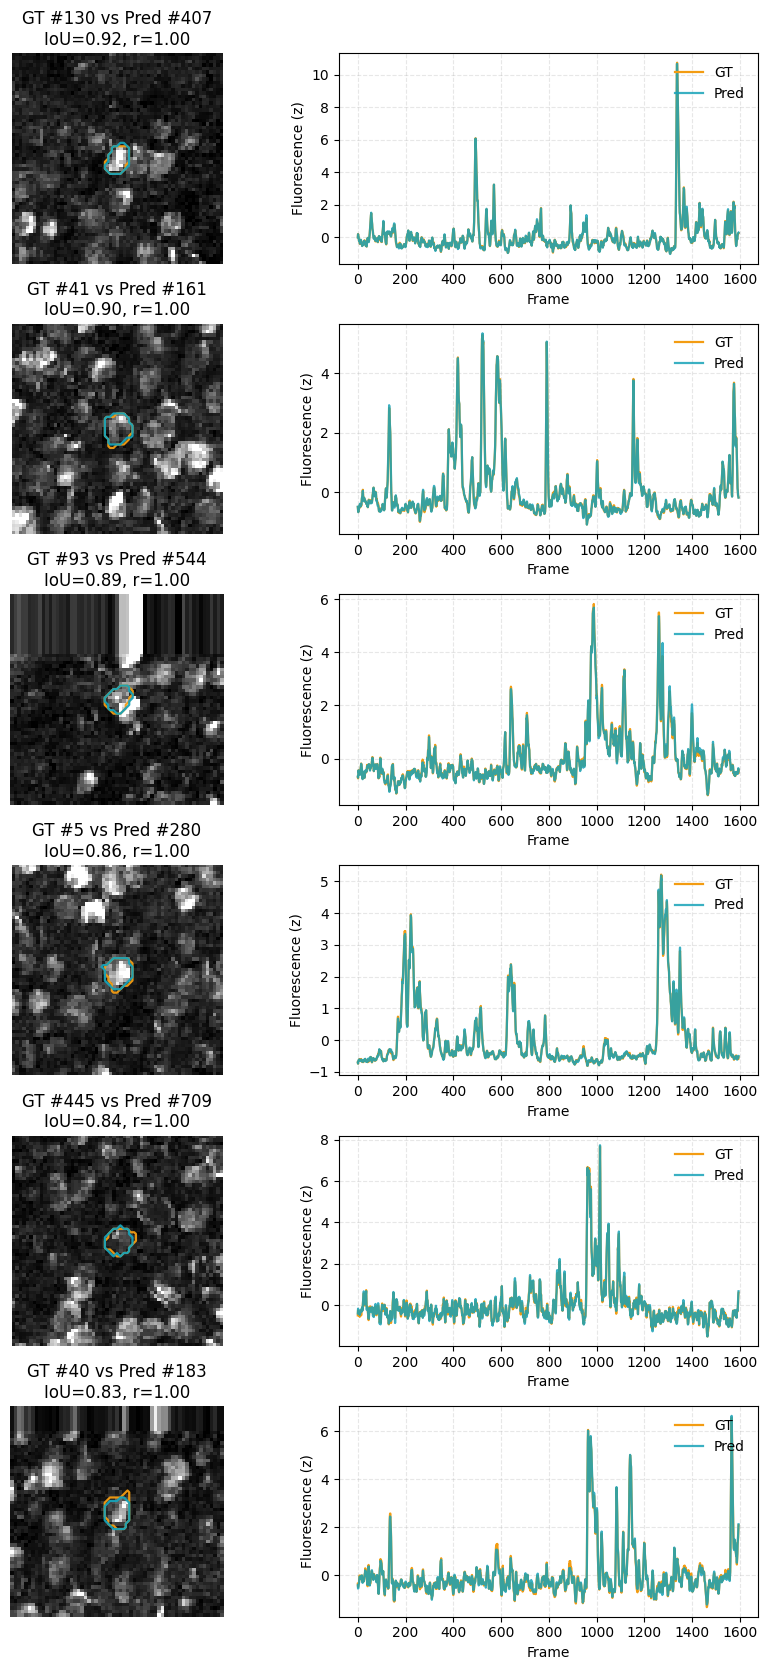

In [9]:
# show 6 best-overlap pairs
show_pairs_overlay_and_traces(
    video_TYX=network_input, 
    gt_masks=gt_masks,
    pred_masks=pred_masks,
    pairs=None,            # let it compute matches
    iou_threshold=0.30,    # only confident matches
    n_pairs=6,             # rows to display
    half=30,               # crop radius
    global_regress=True,
    zscore_tr=True,
    sort_by="IoU"
)


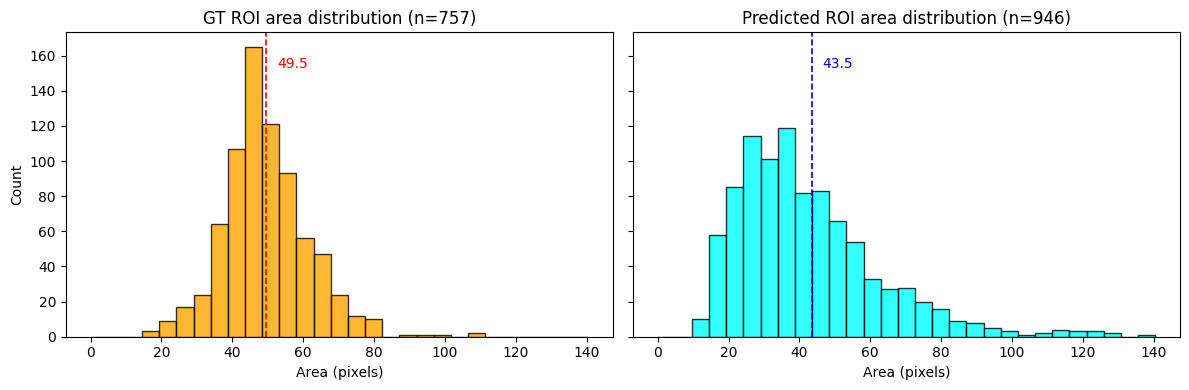

In [12]:
# --- ROI Area distributions (bar graphs + mean markers) ---
# Compute per-ROI areas in pixels
areas_gt = gt_masks.reshape(gt_masks.shape[0], -1).sum(axis=1) if gt_masks.size else np.array([])
areas_pr = pred_masks.reshape(pred_masks.shape[0], -1).sum(axis=1) if pred_masks.size else np.array([])

# Use common bins for fair comparison
all_areas = np.concatenate([areas_gt, areas_pr]) if areas_gt.size and areas_pr.size else (areas_gt if areas_gt.size else areas_pr)
if all_areas.size:
    hi = np.percentile(all_areas, 99.5)
    bins = np.linspace(0, hi, 30)
else:
    bins = 30

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# GT bar graph + mean
ax[0].hist(areas_gt, bins=bins, color='orange', alpha=0.8, edgecolor='k')
ax[0].set_title(f'GT ROI area distribution (n={len(areas_gt)})')
ax[0].set_xlabel('Area (pixels)')
ax[0].set_ylabel('Count')
if areas_gt.size:
    mean_gt = float(np.mean(areas_gt))
    ax[0].axvline(mean_gt, color='red', linestyle='--', linewidth=1.2)
    ymax = ax[0].get_ylim()[1]
    xmin, xmax = ax[0].get_xlim()
    offset = 0.02 * (xmax - xmin)
    ax[0].text(min(mean_gt + offset, xmax), 0.92*ymax, f'{mean_gt:.1f}', color='red', ha='left', va='top')

# Pred bar graph + mean
ax[1].hist(areas_pr, bins=bins, color='cyan', alpha=0.8, edgecolor='k')
ax[1].set_title(f'Predicted ROI area distribution (n={len(areas_pr)})')
ax[1].set_xlabel('Area (pixels)')
if areas_pr.size:
    mean_pr = float(np.mean(areas_pr))
    ax[1].axvline(mean_pr, color='blue', linestyle='--', linewidth=1.2)
    ymax = ax[1].get_ylim()[1]
    xmin, xmax = ax[1].get_xlim()
    offset = 0.02 * (xmax - xmin)
    ax[1].text(min(mean_pr + offset, xmax), 0.92*ymax, f'{mean_pr:.1f}', color='blue', ha='left', va='top')

plt.tight_layout(); plt.show()


GT  mean circularity:  0.753 ± 0.119
Pred mean circularity: 0.704 ± 0.165


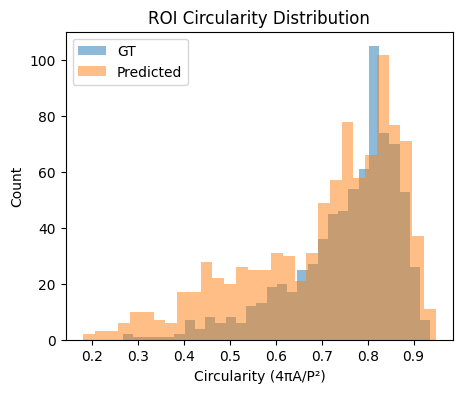

In [13]:
from skimage import measure

def compute_circularity(masks):
    """
    Compute circularity for each binary mask in the stack.
    Circularity = 4π * Area / (Perimeter²)
    Returns list of circularity values and perimeters.
    """
    circularities, perimeters, areas = [], [], []

    for i, mask in enumerate(masks):
        mask = mask.astype(bool)
        if not np.any(mask):
            circularities.append(np.nan)
            perimeters.append(0)
            areas.append(0)
            continue

        # Area = number of pixels
        area = np.sum(mask)
        areas.append(area)

        # Extract contours and measure perimeter in pixels
        contours = measure.find_contours(mask, 0.5)
        perim = 0.0
        for c in contours:
            diff = np.diff(c, axis=0)
            perim += np.sum(np.sqrt((diff ** 2).sum(axis=1)))
        perimeters.append(perim)

        # Circularity formula (avoid division by 0)
        circ = 4 * np.pi * area / (perim ** 2 + 1e-8)
        circularities.append(circ)

    return np.array(circularities), np.array(perimeters), np.array(areas)


# ---- Compute shape metrics for both GT and predictions ----
circ_gt, perim_gt, area_gt = compute_circularity(gt_masks)
circ_pr, perim_pr, area_pr = compute_circularity(pred_masks)

print(f"GT  mean circularity:  {np.nanmean(circ_gt):.3f} ± {np.nanstd(circ_gt):.3f}")
print(f"Pred mean circularity: {np.nanmean(circ_pr):.3f} ± {np.nanstd(circ_pr):.3f}")

# ---- Optional visualization ----
plt.figure(figsize=(5,4))
plt.hist(circ_gt, bins=30, alpha=0.5, label='GT')
plt.hist(circ_pr, bins=30, alpha=0.5, label='Predicted')
plt.xlabel('Circularity (4πA/P²)')
plt.ylabel('Count')
plt.legend()
plt.title('ROI Circularity Distribution')
plt.show()

# Each bar shows how many ROIs have a given circularity value. circularity= 4πA/P²: 1.0 means a perfect circle; lower values mean more elongated/irregular shapes.
# GT = 0.753, Pred = 0.841 mean the predicted ROIs are, on average, rounder and more uniform than the GT. The broader GT histogram indicates more shape 
# variety (irregular/merged cells).
# Any values slightly above 1 are due to pixel-grid/perimeter approximation; they’re harmless. If you want tighter estimates, compute perimeter with a sub‑pixel
#  method (e.g., skimage.measure.perimeter) or lightly smooth masks before measuring.

In [17]:
from scipy.optimize import linear_sum_assignment


def compute_f1_from_overlap(overlap_matrix, thr=0.5):
    """
    Computes TP/FP/FN and F1 based on the bidirectional overlap matrix.
    Matching is done via Hungarian assignment using overlap >= thr.
    """
    if overlap_matrix.size == 0:
        return dict(TP=0, FP=0, FN=0, precision=0.0, recall=0.0, f1=0.0)

    N_gt, N_pr = overlap_matrix.shape

    # cost matrix = 1 - overlap (we want to maximize overlap)
    cost = 1.0 - overlap_matrix
    cost[overlap_matrix < thr] = 1e6  # forbid low-overlap pairs

    # Hungarian matching (optimal one-to-one matches)
    row_ind, col_ind = linear_sum_assignment(cost)
    matched = overlap_matrix[row_ind, col_ind] >= thr
    TP = int(matched.sum())
    FP = N_pr - TP
    FN = N_gt - TP

    precision = TP / (TP + FP + 1e-8)
    recall    = TP / (TP + FN + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    return dict(TP=TP, FP=FP, FN=FN, precision=precision, recall=recall, f1=f1)


# ---- Try for a few thresholds ----
thr_list = [0.2, 0.3, 0.5, 0.7]
for thr in thr_list:
    res = compute_f1_from_overlap(overlap, thr)
    print(f"Threshold ≥ {thr:.2f} | TP={res['TP']} FP={res['FP']} FN={res['FN']} "
          f"| P={res['precision']:.3f} R={res['recall']:.3f} F1={res['f1']:.3f}")

# ---- Visualize 5 matched examples per threshold ----
for thr in thr_list:
    if overlap.size == 0:
        continue
    cost = 1.0 - overlap
    cost[overlap < thr] = 1e6
    row_ind, col_ind = linear_sum_assignment(cost)

    pairs = [(int(g), int(p), float(overlap[g, p]))
             for g, p in zip(row_ind, col_ind) if overlap[g, p] >= thr]
    if not pairs:
        continue
    pairs.sort(key=lambda x: x[2], reverse=True)
    sel = pairs[:5]
    grid_pairs = [(g, p, f'Thr≥{thr:.2f} overlap={ovv:.2f}') for g, p, ovv in sel]
    _plot_pairs_grid(grid_pairs, f'Examples of matches at thr≥{thr:.2f}')


NameError: name 'overlap' is not defined

In [18]:
# --- Confidence curves (SUNS vs Suite2p) using masks-only confidences ---
import numpy as np
import matplotlib.pyplot as plt


def plot_confidence_sigmoids(prob_suns, prob_s2p, smooth_window=21, thresholds=(0.3, 0.5, 0.7)):
    """
    Plots confidence-only curves for SUNS and Suite2p.
    X-axis = normalized ROI rank (low→high confidence), Y-axis = cell probability.
    """
    def sort_asc(y):
        return y[np.argsort(y)]

    def smooth(y, w=21):
        if w < 3 or (w % 2 == 0):  # require odd window >=3
            return y
        pad = w // 2
        ypad = np.pad(y, (pad, pad), mode='edge')
        kernel = np.ones(w) / w
        return np.convolve(ypad, kernel, mode='valid')

    # Convert inputs to arrays
    prob_suns = np.asarray(prob_suns, dtype=float)
    prob_s2p  = np.asarray(prob_s2p,  dtype=float)

    # Sort each method by its own confidence (ascending)
    y_suns = sort_asc(prob_suns)
    y_s2p  = sort_asc(prob_s2p)

    # Normalized rank (0..1)
    x_suns = np.linspace(0, 1, len(y_suns), endpoint=False)
    x_s2p  = np.linspace(0, 1, len(y_s2p), endpoint=False)

    # Light smoothing for a sigmoid look (keeps length)
    ys_suns = smooth(y_suns, w=smooth_window)
    ys_s2p  = smooth(y_s2p,  w=smooth_window)

    # ---- Plot
    plt.figure(figsize=(10, 5))
    # ROI points only (no smoothed lines)
    plt.scatter(x_s2p,  y_s2p,  s=12, alpha=0.35, color='royalblue',  label='Suite2p')
    plt.scatter(x_suns, y_suns, s=12, alpha=0.35, color='darkorange', label='SUNS')

    # Optional probability thresholds
    for thr in thresholds:
        plt.axhline(thr, linestyle='--', alpha=0.35, color='gray')
        plt.text(0.995, thr + 0.01, f"thr={thr}", ha='right', va='bottom', fontsize=9)

    plt.xlabel('Normalized ROI rank (low → high confidence)')
    plt.ylabel('Cell probability (confidence)')
    plt.title('Confidence curves (SUNS vs Suite2p) — via best-IoU support')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Derive confidences from masks only (no Fall.mat): best IoU support
#  - SUNS confidence: for each SUNS predicted ROI, max IoU with any Suite2p GT ROI
#  - Suite2p confidence: for each Suite2p GT ROI, max IoU with any SUNS predicted ROI

def _max_iou_per_row(A, B):
    if A.size == 0:
        return np.array([], dtype=float)
    if B.size == 0:
        return np.zeros(A.shape[0], dtype=float)
    I = pairwise_iou(A.astype(bool), B.astype(bool))
    return (I.max(axis=1) if I.size else np.zeros(A.shape[0], dtype=float)).astype(float)

conf_suns = _max_iou_per_row(pred_masks, gt_masks)  # SUNS supported by GT
conf_s2p  = _max_iou_per_row(gt_masks, pred_masks)  # GT supported by SUNS

# Plot curves
plot_confidence_sigmoids(prob_suns=conf_suns, prob_s2p=conf_s2p, smooth_window=21)


NameError: name 'pairwise_iou' is not defined